In [1]:
import torch
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from pathlib import Path
import numpy as np
from PIL import Image
from torch import nn
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import torch.nn.functional as F

from tqdm import tqdm

In [2]:
torch.cuda.empty_cache()

# Датасет

In [3]:
def get_yolo_data(image_path, labels_root):
    label_path = labels_root / (image_path.stem + ".txt")

    bboxes, labels = [], []

    if not label_path.exists():
        return bboxes, labels

    with open(label_path) as f:
        for line in f:
            cls, x1, y1, x2, y2 = map(float, line.split())
            bboxes.append([x1, y1, x2, y2, int(cls)])

    return bboxes

In [4]:
class YoloDataset(torch.utils.data.Dataset):
    def __init__(self, *, root, transform=None, train=True):
        self.root = Path(root)
        self.transform = transform

        split = "train" if train else "test"

        self.images_dir = self.root / split / "images"
        self.labels_dir = self.root / split / "baseline_labels"

        self.images = sorted(self.images_dir.glob("*"))

    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = np.array(Image.open(image_path).convert("RGB"))

        bboxes = get_yolo_data(image_path, self.labels_dir)

        return self.transform(image=image, bboxes=bboxes)

    def __len__(self):
        return len(self.images)


In [5]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_transform = A.Compose(
    [   A.Resize(640, 640),
        A.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=dict(format="pascal_voc", min_visibility=0.3),
)

test_transform = A.Compose(
    [   A.Resize(640, 640),
        A.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=dict(format="pascal_voc", min_visibility=0.0),
)

In [6]:
train_ds = YoloDataset(root="data/YOLO", transform=train_transform, train=True)
test_ds = YoloDataset(root="data/YOLO", transform=test_transform, train=False)

# Визуализация

In [7]:
def visualize(images, bboxes):
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)

    fig, axes = plt.subplots(
        2, len(images) // 2 + len(images) % 2, figsize=(10, 8), dpi=100
    )

    for i, ax in enumerate(axes.reshape(-1)):

        ax.axis(False)

        if i >= len(images):
            break

        img = images[i].permute(1, 2, 0).numpy()
        img = (img * std) + mean
        img = np.clip(img, 0, 1)
        ax.imshow(img)

        for bbox in bboxes[i]:
            xmin, ymin, xmax, ymax, class_id = bbox
            rect = Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(xmin, ymin - 5, class_id, fontsize=8, color='r')

    fig.tight_layout()
    plt.show()

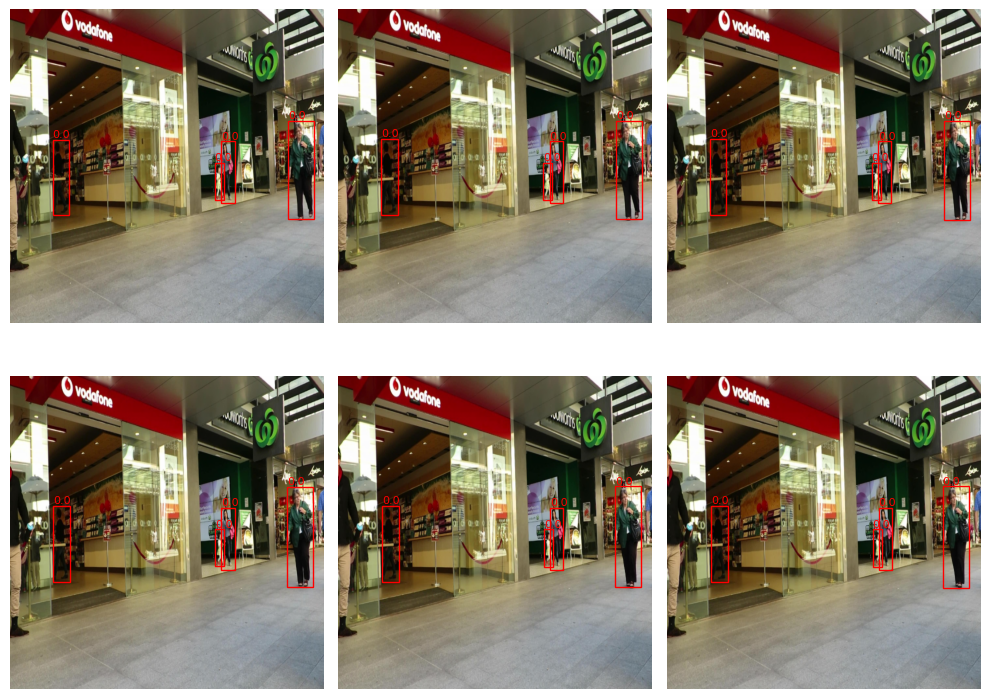

In [8]:
out = [train_ds[i] for i in range(6)]
visualize([o["image"] for o in out], [o["bboxes"] for o in out])

# YOLO-like

## Collate fun

In [ ]:
def collate_fn(batch, downsample=32):
    imgs, batch_boxes = map(list, (zip(*[(b["image"], b["bboxes"]) for b in batch])))

    imgs = torch.stack(imgs)
    b, _, h, w = imgs.shape

    target = imgs.new_zeros(b, 6, h // downsample, w // downsample)

    for i, boxes in enumerate(batch_boxes):
        if len(boxes) == 0:
            continue
        xmin, ymin, xmax, ymax, classes = map(
            torch.squeeze, torch.split(imgs.new_tensor(boxes), 1, dim=-1)
        )

        w_box = (xmax - xmin)/w
        h_box = (ymax - ymin)/h

        cx = (xmin + xmax)/2
        cy = (ymin + ymax)/2
        cx_idx = (cx//downsample).long()
        cy_idx = (cy//downsample).long()

        cx_box = (cx%downsample)/downsample
        cy_box = (cy%downsample)/downsample

        target[i, :, cy_idx, cx_idx] = torch.stack(
            [cx_box, cy_box, w_box, h_box, torch.ones_like(cx_box), classes]
        )

    return {"image": imgs, "target": target}

## Decoder fun

In [10]:
def decode_prediction(pred, upsample=32, threshold=0.7):
    b, c, h, w = pred.shape
    img_w, img_h = w * upsample, h * upsample
    boxes = []
    for batch in range(b):
        for x in range(w):
            for y in range(h):
                cx_box, cy_box, w_box, h_box, obj_prob = pred[batch, :5, y, x]

                if c == 6:
                    class_idx = pred[batch, 5, y, x]
                else:
                    class_probs = pred[batch, 5:, y, x]
                    class_idx = class_probs.argmax()

                if obj_prob > threshold:
                    range_x = w_box*img_w
                    range_y = h_box*img_h
                    bias_cx = cx_box*upsample
                    bias_cy = cy_box*upsample
                    cx = upsample*x + bias_cx
                    cy = upsample*y + bias_cy
                    xmin = cx - range_x/2
                    xmax = cx + range_x/2
                    ymin = cy - range_y/2
                    ymax = cy + range_y/2

                    boxes.append((int(xmin), int(ymin), int(xmax), int(ymax), int(class_idx)))

    return boxes

# Архитектура

In [11]:
C = 6
import torchvision.models as models

class Detector(nn.Module):
    def __init__(self):
        super().__init__()

        resnet = models.resnet50(pretrained=True)
        self.resnet_blocks = nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu,
            resnet.maxpool,
            resnet.layer1,
            resnet.layer2,
            resnet.layer3,
            resnet.layer4
        )


        self.additional_blocks = nn.Sequential(
            nn.Conv2d(2048, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 5 + C, kernel_size=3, padding=1)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, img):
        x = self.resnet_blocks(img)
        x = self.additional_blocks(x)
        x = self.sigmoid(x)

        return x

# Функция потерь

In [12]:
def special_loss(pred, target, check=False, C=C):
    mask = target[:, 4, :, :] > 0

    localization_loss = nn.MSELoss(reduction='sum')(
        torch.masked_select(target[:, 0, :, :], mask), torch.masked_select(pred[:, 0, :, :], mask)) + nn.MSELoss(reduction='sum')(
        torch.masked_select(target[:, 1, :, :], mask), torch.masked_select(pred[:, 1, :, :], mask))

    box_loss = nn.MSELoss(reduction='sum')(torch.masked_select(target[:, 2, :, :] ** 0.5, mask), torch.masked_select(pred[:, 2, :, :], mask)
        ) + nn.MSELoss(reduction='sum')(torch.masked_select(target[:, 3, :, :] ** 0.5, mask), torch.masked_select(pred[:, 3, :, :], mask))

    arr = []
    for index in range(C):
        arr.append(torch.masked_select(pred[:, 5+index, :, :], mask))
    pr = torch.stack(arr, 1)
    tar = torch.masked_select(target[:, 5, :, :], mask)
    classification_loss = nn.CrossEntropyLoss(reduction='sum')(pr, tar.long())

    confidence_loss = nn.BCELoss(reduction='sum')(torch.masked_select(pred[:, 4, :, : ], mask), torch.masked_select(target[:, 4, :, : ], mask)
        ) + 0.1 * nn.BCELoss(reduction='sum')(torch.masked_select(pred[:, 4, :, : ], ~mask
        ), torch.masked_select(target[:, 4, :, : ], ~mask))


    if not check:
        return 10 * localization_loss + box_loss + classification_loss + confidence_loss

    else:
        return localization_loss, box_loss, classification_loss, confidence_loss

# Обучение

In [13]:
loader = torch.utils.data.DataLoader(train_ds, 6, collate_fn=collate_fn)

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(21)
EPOCHS = 30
model = Detector().to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)

for e in range(EPOCHS):
    epoch_losses = []
    for batch in tqdm(loader):

        imgs = batch["image"].to(device)
        targets = batch["target"].to(device)

        opt.zero_grad()
        outputs = model(imgs)
        loss = special_loss(outputs, targets)
        loss.backward()
        opt.step()
        epoch_losses.append(loss.item())

    print(f"Epoch {e} done; Train loss {np.mean(epoch_losses):.3f};")

 10%|▉         | 565/5936 [03:19<31:39,  2.83it/s]


ValueError: not enough values to unpack (expected 5, got 1)

# Тест

In [ ]:
test_loader = torch.utils.data.DataLoader(test_ds, 6, collate_fn=collate_fn)
i = iter(test_loader)
batch = next(i)

images, target = batch['image'], batch['target']

pred = []
for image in images:
    image = image.unsqueeze(0)
    with torch.no_grad():
        outputs = model(image.to(device))
        pred.append(outputs.to('cpu'))
        
visualize([img for img in images], [decode_prediction(result) for result in pred])